# 202202_SimplestRun

# 1. Connect & Load Data

In [31]:
import os; from importlib import reload;
from utils.constants import *
%cd {os.environ['PROJECT_PATH']}

/app


In [32]:
from data import load_data; reload(load_data)

# load_data.fetch_data_from_local(folder='data/raw_mat/', pattern='LLV')
dfBpAll, dfImuAll = load_data.load_dataframe_from_mat(folder='data/raw_mat/', pattern='LLV')

/usr/local/lib/python3.8/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
/usr/local/lib/python3.8/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
/usr/local/lib/python3.8/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
/usr/local/lib/python3.8/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.

# 2. Process Signal Data in Heartbeats

In [33]:
from utils import constants
from data import preprocess

dfAll = preprocess.merge_imu_vcg_with_heartbeats(dfBpAll, dfImuAll)

/app/src/data/preprocess.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfBpAll = dfBpAll.append(BpTargets)
/app/src/data/preprocess.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfImuRawAll = dfImuRawAll.append(dfImuSamp)
/app/src/data/preprocess.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfBpAll = dfBpAll.append(BpTargets)
/app/src/data/preprocess.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfImuRawAll = dfImuRawAll.append(dfImuSamp)
/app/src/data/preprocess.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  

# 3. Define Data Splits (Patients, Heartbeats, etc)

In [34]:
from models import experiments

dfImu = dfAll[constants.INDICIES + constants.IMU_COLS]
dfBp = dfAll[constants.INDICIES + constants.BP_COLS]

sampleRandTestInds = experiments.split_by_random(dfImu, dfBp)
sampleExpDfs = experiments.get_experiment(sampleRandTestInds[0], dfImu, dfBp)

# 4. Modeling Pipelines (Baselines & Analytical)

In [35]:
from models import analytical_mvd
tsExplodeTransform = preprocess.FunctionTransformer(partial(preprocess.explode_3d, data_cols=['az','ax']))

from models import baselines, analytical_mvd
from sklearn.pipeline import Pipeline

pipe_random = Pipeline([('scaler', tsExplodeTransform), ('rand', baselines.RandomRegressor())])
pipe_mean = Pipeline([('scaler', tsExplodeTransform), ('rand', baselines.DummyRegressor())])
pipe_mvd = Pipeline([('scaler', tsExplodeTransform), ('rand', analytical_mvd.AnalyticalBPEstimator())])

In [36]:
from sklearn.metrics import mean_absolute_error

for pipe in [pipe_random, pipe_mean, pipe_mvd]:
    pipe.fit(sampleExpDfs['train_x'], sampleExpDfs['train_y'].groupby(constants.INDICIES)['dbp'].mean())
    score = mean_absolute_error(
        pipe.predict(sampleExpDfs['test_x']),
        sampleExpDfs['test_y'].groupby(constants.INDICIES)['dbp'].mean()
    )
    print('Achieved Score (MAE) : ', score, pipe)

Achieved Score (MAE) :  11.64085967270392 Pipeline(steps=[('scaler',
                 FunctionTransformer(func=functools.partial(<function explode_3d at 0x7feec523baf0>, data_cols=['az', 'ax']))),
                ('rand',
                 <models.baselines.RandomRegressor object at 0x7feea59535b0>)])
Achieved Score (MAE) :  9.196390544221254 Pipeline(steps=[('scaler',
                 FunctionTransformer(func=functools.partial(<function explode_3d at 0x7feec523baf0>, data_cols=['az', 'ax']))),
                ('rand', DummyRegressor())])
Fitted Parameters :  {'k1': 10000.0, 'k2': 68.0}
Achieved Score (MAE) :  8.930666023257768 Pipeline(steps=[('scaler',
                 FunctionTransformer(func=functools.partial(<function explode_3d at 0x7feec523baf0>, data_cols=['az', 'ax']))),
                ('rand', AnalyticalBPEstimator(k1=10000.0, k2=68.0))])


# 5. Evaluation

In [37]:
pipe = pipe_mvd

train_y = sampleExpDfs['train_y'].groupby(constants.INDICIES)['dbp'].mean()
test_y = sampleExpDfs['test_y'].groupby(constants.INDICIES)['dbp'].mean()

pipe.fit(sampleExpDfs['train_x'], train_y)
preds = pipe.predict(sampleExpDfs['test_x'])

score_mae = mean_absolute_error(preds, test_y)
print('Achieved Score (MAE) : ', score)

Fitted Parameters :  {'k1': 10000.0, 'k2': 68.0}
Achieved Score (MAE) :  8.930666023257768


<AxesSubplot:xlabel='target', ylabel='preds'>

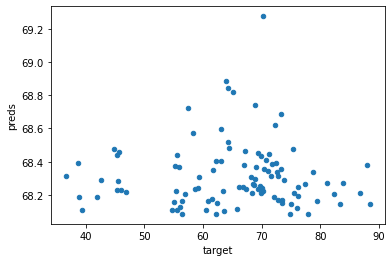

In [43]:
pd.DataFrame([preds, test_y], ['preds','target']).T.plot.scatter(1,0)